In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit

from processing import forward_fill

# Affect of p on performance with different costs

In [2]:
def filter_and_include(group, max_budget):
    # Filter to include all rows <= budget
    within_budget = group[group['total_c'] <= max_budget]
    max_within_budget = within_budget['total_c'].max()
    # Check if the max within budget is less than the budget
    if max_within_budget < max_budget:
        # Try to get the smallest value >= budget
        exceeds_budget = group[group['total_c'] >= max_budget]
        if not exceeds_budget.empty:
            # Concatenate the first row where total_c >= budget
            within_budget = pd.concat([within_budget, exceeds_budget.iloc[:1]])
        else:
            # Print the keys of the group to identify the issue
            display(group.tail())
    return within_budget


# Function to plot performance gap for each problem
def plot_gap_based_on_costs(problem_df, problem_name, plot_mean=False, budget=10, ignore_init_cost=True):
    # Assert that there's only one dimension
    assert len(problem_df['dim'].unique()) == 1, "The DataFrame should only contain one dimension"
    # Assert that there's only one xcs
    assert len(problem_df['xcs'].unique()) == 1, "The DataFrame should only contain one xcs"
    
    # Get dim and xcs values
    dim = problem_df['dim'].unique()[0]
    xcs = problem_df['xcs'].unique()[0]
    
    # Set up the plot
    plt.figure(figsize=(8, 5))

    # Make labels and ticks larger
    plt.rc('xtick', labelsize=12)  # Adjust to your liking
    plt.rc('ytick', labelsize=12)
    plt.rc('axes', labelsize=14)
    
    switch_costs = [1, 2, 4, 8, 16]

    # Plot lines for multiple budgets
    performance = pd.DataFrame()
    for switch_cost in switch_costs:
        # New column switch_cost (as opposed to switching_cost column)
        problem_df['switch_cost'] = switch_cost

        # Map fixed_feature boolean to metric_c - if true then 1, else switch_cost
        problem_df['metric_c'] = problem_df['fixed_feature'].map({True: 1, False: switch_cost})

        # Groupby 'problem', 'p', 'run', and create "total_c" as the cumsum of "metric_c"
        problem_df['total_c'] = problem_df.groupby(['problem', 'p', 'run'])['metric_c'].cumsum()

        if ignore_init_cost:
            # Ignore the initial cost by increasing the budget (2 * dim * switch_cost)
            total_budget = (budget + 2) * dim * switch_cost
        else:
            total_budget = budget * dim * switch_cost

        # Filter until the budget is exhausted
        budget_df = problem_df.groupby(['problem', 'p', 'run', 'switch_cost']).apply(lambda x: filter_and_include(x, total_budget)).reset_index(drop=True)
        # Check if any max total cost is less than the budget for each group
        assert budget_df.groupby(['problem', 'p', 'run', 'switch_cost'])['total_c'].max().min() >= total_budget, f"Budget is not exhausted for all runs, switch cost is {switch_cost}"
                
        # Filter the DataFrame for the last index of each budget
        budget_df = budget_df[budget_df['total_c'] <= total_budget]

        # Groupby 'problem', 'p', 'run', and get the max gap
        performance_df = budget_df.groupby(['problem', 'p', 'run', 'switch_cost'])['gap'].max().reset_index()

        # Append to performance DataFrame
        performance = pd.concat([performance, performance_df], ignore_index=True)

    # Average performance across problems
    performance = performance.groupby(['p', 'run', 'switch_cost'])['gap'].mean().reset_index()
    
    if plot_mean:
        # After processing all switch costs, calculate the mean gap for each 'p'
        mean_performance = performance.groupby('p')['gap'].mean().reset_index(name='mean_gap')
    
        # Plotting the mean line with the calculated values
        sns.lineplot(data=mean_performance, x='p', y='mean_gap', color='black', linestyle='--', label='Mean Gap')

    # Plot lineplot for each budget
    sns.lineplot(data=performance, x='p', y='gap', hue = "switch_cost", errorbar=('ci', 95), palette='Set1')

    # Plot vertical lines with annotations for each p
    for k in switch_costs[1:]:
        p_value = 1 - 1 / k
        plt.axvline(x=p_value, color='grey', linestyle='--')

        # Get current axes
        ax = plt.gca()

        # Adjust the text placement relative to the data coordinates and use transform to place text in axis coordinates
        ax.text(p_value, -0.05, f'k={k}', rotation=90, verticalalignment='center', horizontalalignment='center', transform=ax.transAxes, fontsize=12)

    # Update the legend with a title to specify what the switch_cost values mean
    # This assumes that the rest of your plot code is correct and sns.lineplot has been called
    handles, labels = plt.gca().get_legend_handles_labels()
    switch_cost_labels = ['1 (Traditional OP)'] + [f'{sc}' for sc in switch_costs[1:]]

    if plot_mean:
        # If mean is plotted, update the legend to include it
        new_labels = ['Mean (Avg. Trend)'] + switch_cost_labels
    else:
        new_labels = switch_cost_labels

    # Finalize and show the updated legend
    legend = plt.legend(handles=handles, labels=new_labels, title='Switch Costs', fontsize='large')
    # Set the fontsize of the legend title
    legend_title_fontsize = 14  # Adjust the size as needed
    legend.get_title().set_fontsize(legend_title_fontsize)

    # Finalize plot
    plt.title(f'{problem_name.capitalize()} {dim}D {xcs} expensive, N={budget*dim} switches', fontsize=16)
    plt.xlabel(r'$p$ - Probability of Reusing Setup', fontsize=14)
    plt.ylabel('Performance Gap', fontsize=14)

    plt.xlim(0, 1)

    plt.grid(False)
    plt.tight_layout()  # Adjust the layout
    plt.show()

## 2D Results

In [3]:
ptradeoff2d_results = pd.read_csv('results/csv/panalysis2d_results.csv')
ptradeoff2d_results.head()

,index,x0,x1,metric_y,best_y,fixed_feature,metric_c,total_c,algo,k,p,switching_cost,xc_dims,regret,gap,xcs,problem,dim,run
0,0,225.499843,349.523711,-747.813937,-747.813937,False,16.0,16.0,bo_random,NaN,0.95,15,1,747.813937,0.0,1,schwefel,2,12
1,1,121.768414,93.882577,-984.185806,-747.813937,False,16.0,32.0,bo_random,NaN,0.95,15,1,747.813937,0.0,1,schwefel,2,12
2,2,-230.842072,164.026401,-912.423911,-747.813937,False,16.0,48.0,bo_random,NaN,0.95,15,1,747.813937,0.0,1,schwefel,2,12
3,3,-401.731623,-52.911242,-1255.728207,-747.813937,False,16.0,64.0,bo_random,NaN,0.95,15,1,747.813937,0.0,1,schwefel,2,12
4,4,500.000000,-52.911242,-1062.814100,-747.813937,True,1.0,65.0,bo_random,NaN,0.95,15,1,747.813937,0.0,1,schwefel,2,12


In [4]:
sorted(ptradeoff2d_results['p'].unique())[:5]

[0.0, 0.05, 0.1, 0.15, 0.2]

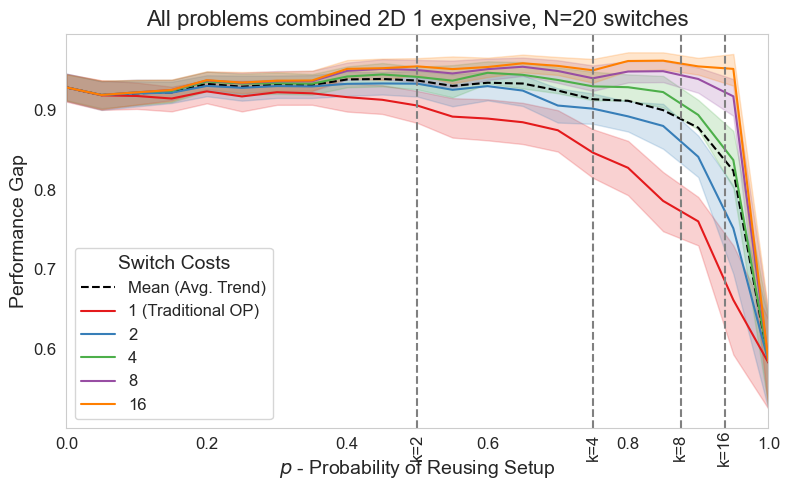

In [5]:
# Apply the function to the entire dataset
plot_gap_based_on_costs(ptradeoff2d_results, 'All Problems Combined', plot_mean=True)

## 3D Results

In [6]:
ptradeoff3d_results = pd.read_csv('results/csv/panalysis3d_results.csv')
ptradeoff3d_results.head()

,index,x0,x1,x2,metric_y,best_y,fixed_feature,metric_c,total_c,algo,k,p,switching_cost,xc_dims,regret,gap,xcs,problem,dim,run
0,0,-26.070031,142.801389,58.230416,-1258.639439,-1258.639439,False,16.0,16.0,bo_random,NaN,0.8,15,0,1258.639439,0.000000,1,schwefel,3,17
1,1,141.670153,334.720435,190.997226,-1338.905394,-1258.639439,False,16.0,32.0,bo_random,NaN,0.8,15,0,1258.639439,0.000000,1,schwefel,3,17
2,2,-265.430980,-499.153681,344.624275,-1036.198066,-1036.198066,False,16.0,48.0,bo_random,NaN,0.8,15,0,1036.198066,0.176732,1,schwefel,3,17
3,3,-440.070721,302.265664,-346.665252,-1851.680905,-1036.198066,False,16.0,64.0,bo_random,NaN,0.8,15,0,1036.198066,0.176732,1,schwefel,3,17
4,4,246.226506,259.160396,486.807880,-1386.868919,-1036.198066,False,16.0,80.0,bo_random,NaN,0.8,15,0,1036.198066,0.176732,1,schwefel,3,17


In [7]:
xcs1_3d = ptradeoff3d_results[ptradeoff3d_results['xcs'] == 1].copy()
xcs2_3d = ptradeoff3d_results[ptradeoff3d_results['xcs'] == 2].copy()

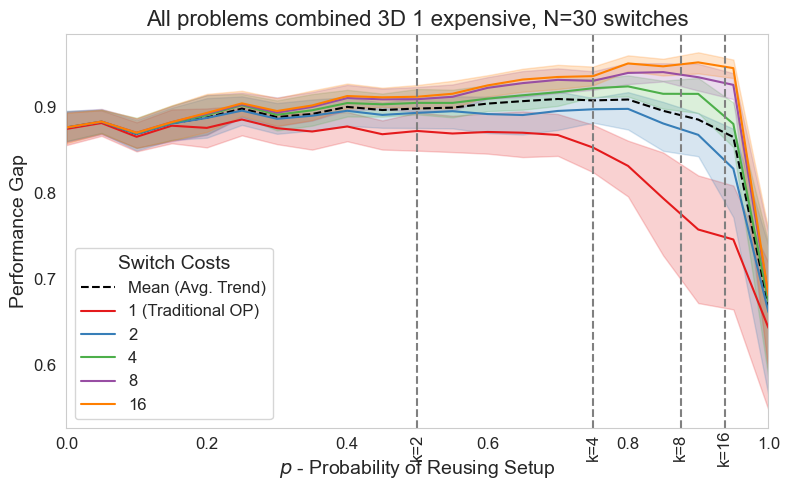

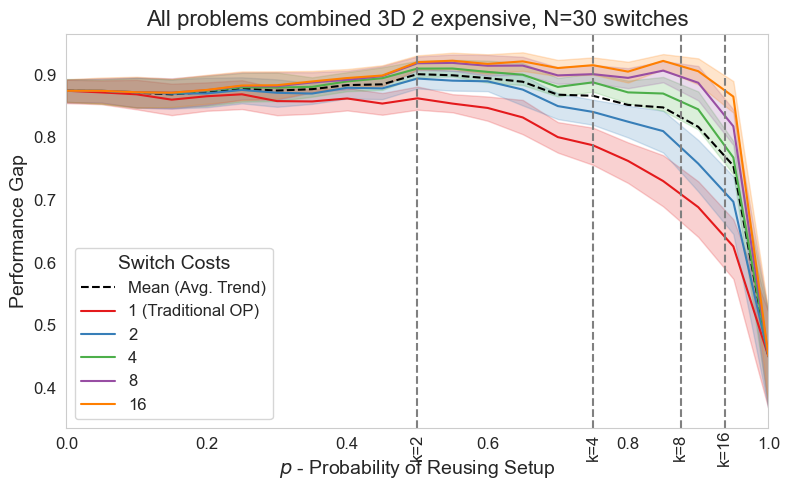

In [8]:
# Apply the function to the entire dataset
plot_gap_based_on_costs(xcs1_3d, 'All Problems Combined', plot_mean=True)
plot_gap_based_on_costs(xcs2_3d, 'All Problems Combined', plot_mean=True)

## 4D Results

In [9]:
ptradeoff4d_results = pd.read_csv('results/csv/panalysis4d_results.csv')
ptradeoff4d_results.head()

,index,x0,x1,x2,x3,metric_y,best_y,fixed_feature,metric_c,total_c,...,k,p,switching_cost,xc_dims,regret,gap,xcs,problem,dim,run
0,0,28.490283,-2.790094,26.172773,-0.654532,-21.495818,-21.495818,False,16.0,16.0,...,NaN,0.2,15,"0,1,2",21.495818,0.000000,3,ackley,4,18
1,1,-7.416849,28.673636,12.457508,6.800232,-21.359688,-21.359688,False,16.0,32.0,...,NaN,0.2,15,"0,1,2",21.359688,0.006333,3,ackley,4,18
2,2,1.912041,27.873916,21.142453,-11.508408,-20.874571,-20.874571,False,16.0,48.0,...,NaN,0.2,15,"0,1,2",20.874571,0.028901,3,ackley,4,18
3,3,3.394866,-1.690073,26.540692,-6.111820,-20.728003,-20.728003,False,16.0,64.0,...,NaN,0.2,15,"0,1,2",20.728003,0.035719,3,ackley,4,18
4,4,1.799516,15.853141,25.262359,19.517488,-21.194163,-20.728003,False,16.0,80.0,...,NaN,0.2,15,"0,1,2",20.728003,0.035719,3,ackley,4,18


In [10]:
xcs1_4d = ptradeoff4d_results[ptradeoff4d_results['xcs'] == 1].copy()
xcs2_4d = ptradeoff4d_results[ptradeoff4d_results['xcs'] == 2].copy()
xcs3_4d = ptradeoff4d_results[ptradeoff4d_results['xcs'] == 3].copy()

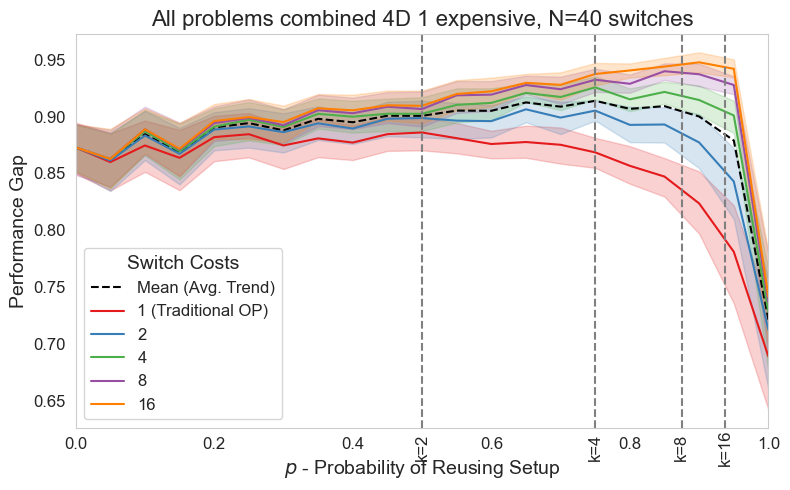

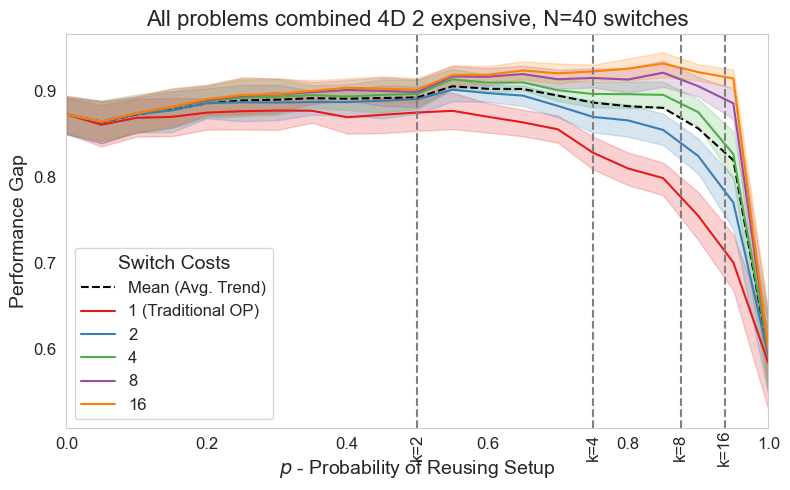

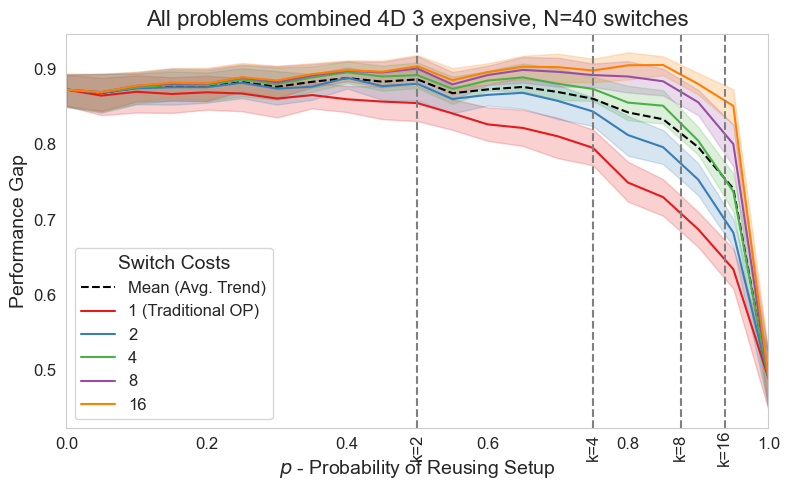

In [11]:
plot_gap_based_on_costs(xcs1_4d, 'All Problems Combined', plot_mean=True)
plot_gap_based_on_costs(xcs2_4d, 'All Problems Combined', plot_mean=True)
plot_gap_based_on_costs(xcs3_4d, 'All Problems Combined', plot_mean=True)

## 4D-1 Results By Problem

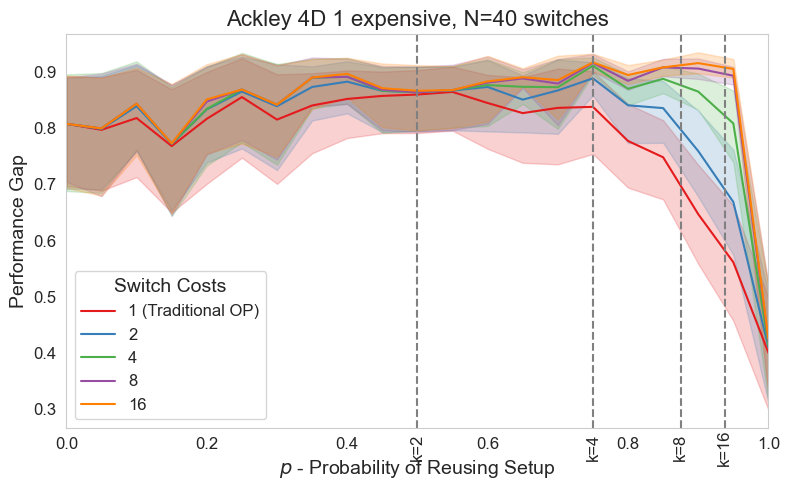

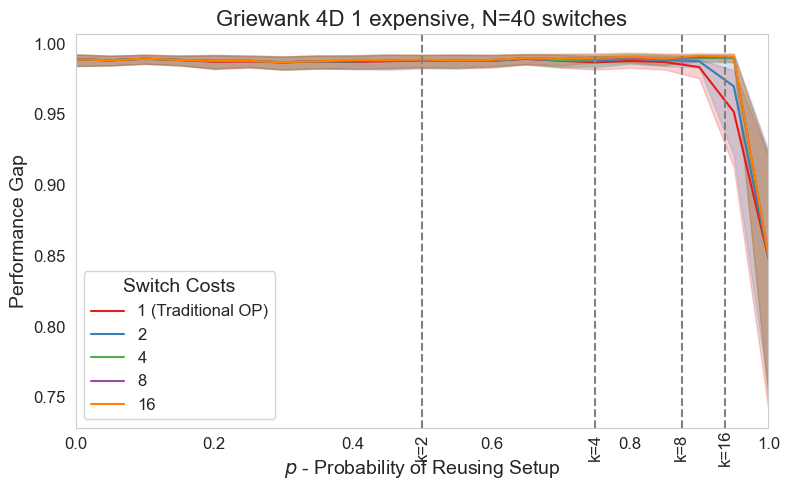

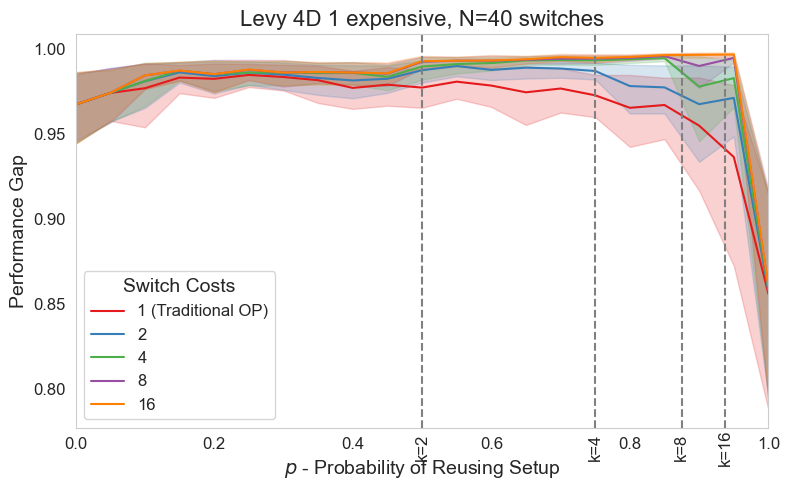

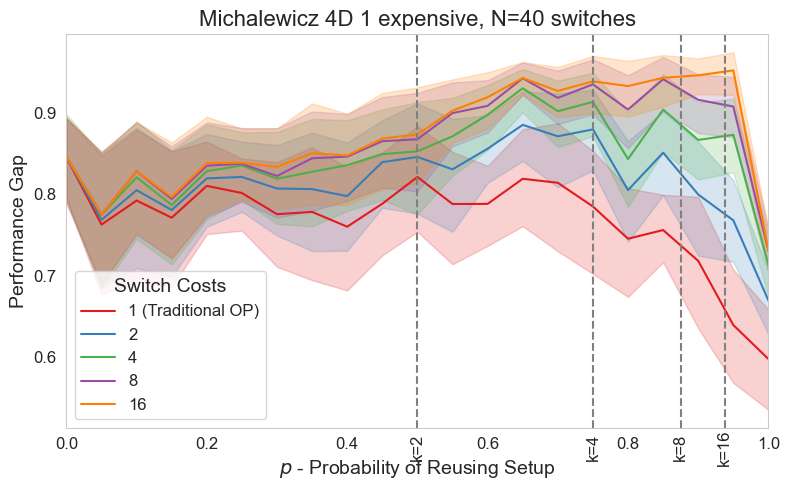

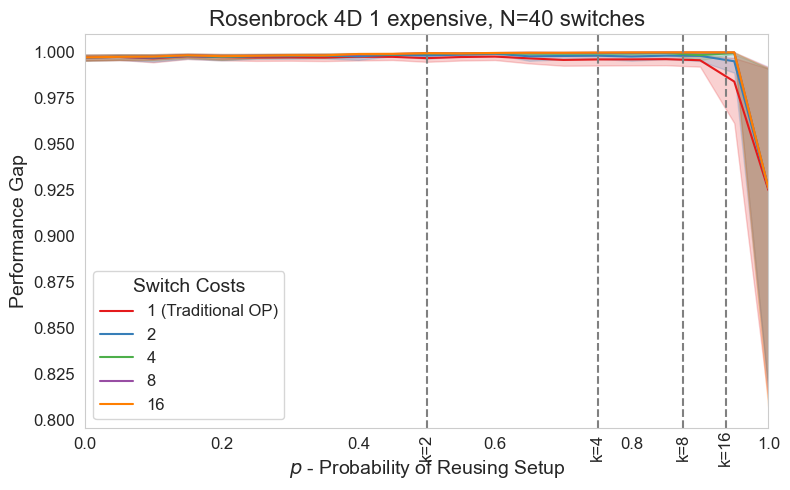

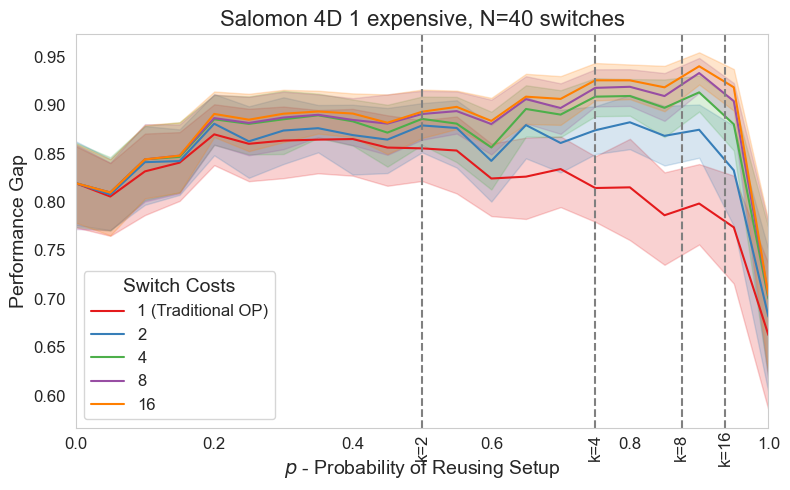

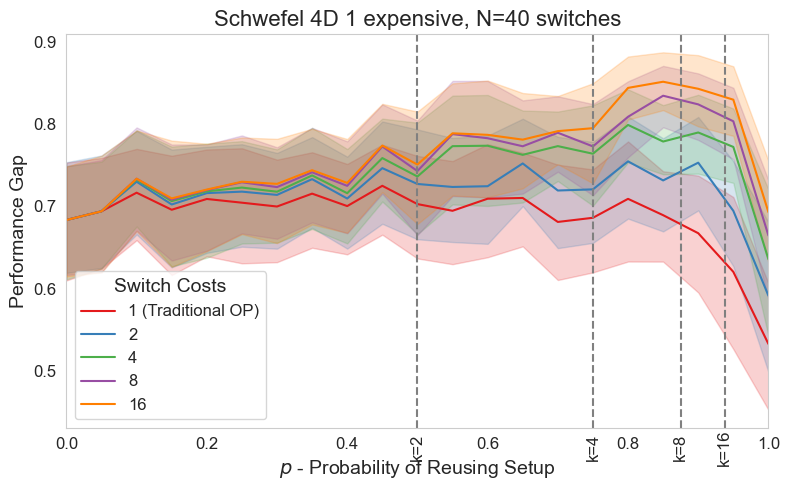

In [12]:
for problem, problem_df in xcs1_4d.groupby('problem'):
    plot_gap_based_on_costs(problem_df, problem)

## Interquartile range p for switch cost ALL

In [13]:
allpdata = pd.concat([ptradeoff2d_results, ptradeoff3d_results, ptradeoff4d_results], ignore_index=True)

In [14]:
# Initialize the figure with appropriate subplots
ignore_init_cost = True
budget = 10
top = 50

switch_costs = [1, 2, 4, 8, 16]

toppdata = pd.DataFrame()
for dim, dpdata in allpdata.groupby('dim'):
    # Plot lines for multiple budgets
    performance = pd.DataFrame()
    for switch_cost in switch_costs:       
        # Replace switch_cost column
        dpdata['switch_cost'] = switch_cost
    
        # Map fixed_feature boolean to metric_c - if true then 1, else switch_cost
        dpdata['metric_c'] = dpdata['fixed_feature'].map({True: 1, False: switch_cost})
    
        # Groupby 'problem', 'p', 'run', and create "total_c" as the cumsum of "metric_c"
        dpdata['total_c'] = dpdata.groupby(['problem', 'dim', 'xcs', 'p', 'run'])['metric_c'].cumsum()
    
        if ignore_init_cost:
            # Ignore the initial cost by increasing the budget (2 * dim * switch_cost)
            total_budget = (budget + 2) * dim * switch_cost
        else:
            total_budget = budget * dim * switch_cost

        # Filter until the budget is exhausted
        budget_df = dpdata.groupby(['problem', 'dim', 'xcs', 'p', 'run', 'switch_cost']).apply(lambda x: filter_and_include(x, total_budget)).reset_index(drop=True)
        # Check if any max total cost is less than the budget for each group
        assert budget_df.groupby(['problem', 'dim', 'xcs', 'p', 'run', 'switch_cost'])['total_c'].max().min() >= total_budget, f"Budget is not exhausted for all runs, switch cost is {switch_cost}"

        # Filter the DataFrame for the last index of each budget
        budget_df = budget_df[budget_df['total_c'] <= total_budget]
    
        # Groupby 'problem', 'p', 'run', and get the max gap
        performance_df = budget_df.groupby(['problem', 'dim', 'xcs', 'p', 'run', 'switch_cost'])['gap'].max().reset_index()
    
        # Append to performance DataFrame
        performance = pd.concat([performance, performance_df], ignore_index=True)
    
    # Assuming 'performance' is already populated with the relevant data as per your loop
    performance = performance.groupby(['dim', 'xcs', 'p', 'run', 'switch_cost'])['gap'].mean().reset_index()
    
    # Get the top 100 gaps per switch cost
    # First, sort the DataFrame by 'switch_cost' and 'gap' descending
    sorted_performance = performance.sort_values(by=['xcs', 'switch_cost', 'gap'], ascending=[True, True, False])
    
    # Then, group by 'switch_cost' and get the top 100 rows for each group
    top_gaps_per_switch_cost = sorted_performance.groupby(['xcs', 'switch_cost']).head(top).reset_index(drop=True)
        
    # Append to top pdata
    toppdata = pd.concat([toppdata, top_gaps_per_switch_cost], ignore_index=True)

<Axes: xlabel='switch_cost', ylabel='p'>

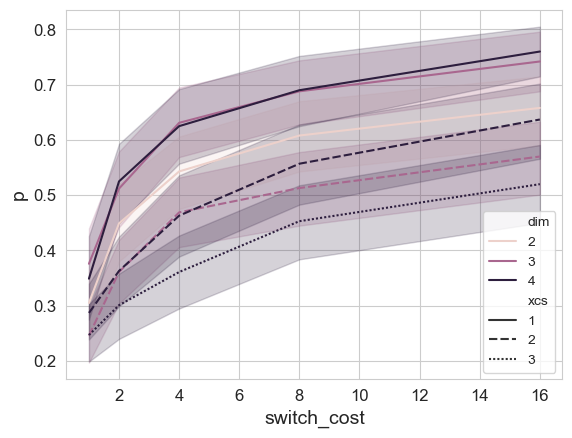

In [15]:
sns.lineplot(data=toppdata, x='switch_cost', y='p', hue='dim', style='xcs', errorbar=('ci', 95))

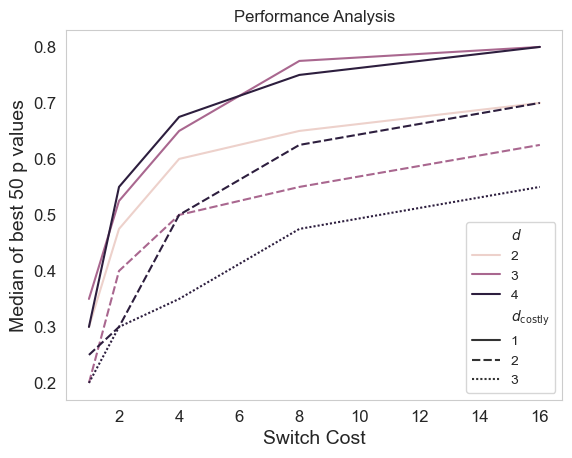

In [16]:
# Creating the plot
ax = sns.lineplot(data=toppdata, x='switch_cost', y='p', hue='dim', style='xcs',
                  estimator='median', errorbar=None)

# Setting labels and title
plt.xlabel('Switch Cost')
plt.ylabel('Median of best 50 p values')
plt.title('Performance Analysis')
plt.grid(False)

# Customizing the legend
handles, labels = ax.get_legend_handles_labels()
new_titles = {'dim': '$d$', 'xcs': '$d_{\mathrm{costly}}$'}  # New titles for legend groups

# Replace the group titles in the labels
new_labels = [new_titles[label] if label in new_titles else label for label in labels]

# Applying the new legend with updated titles
plt.legend(handles=handles, labels=new_labels)
plt.savefig('plots/median_p_values.pdf')
plt.show()

# Archived

## Interquartile range p for switch cost (detailed)

In [17]:
def box_plot_switch(problem_df, problem_name, budget=10, top=100, f=None, best_k=False, ignore_init_cost=True):
    # Assert that there's only one dimension
    assert len(problem_df['dim'].unique()) == 1, "The DataFrame should only contain one dimension"
    # Assert that there's only one xcs
    assert len(problem_df['xcs'].unique()) == 1, "The DataFrame should only contain one xcs"

    # Get dim and xcs values
    dim = problem_df['dim'].unique()[0]
    xcs = problem_df['xcs'].unique()[0]

    # Determine the number of columns for the subplot based on best_k
    ncols = 2 if best_k else 1

    figsize = (16, 6) if best_k else (8, 6)

    # Initialize the figure with appropriate subplots
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=figsize)

    # Adjust for when we only have one subplot to ensure axes is iterable
    if ncols == 1:
        axes = [axes]

    switch_costs = [1, 2, 4, 8, 16]

    # Plot lines for multiple budgets
    performance = pd.DataFrame()
    for switch_cost in switch_costs:
        # Replace switch_cost column
        problem_df['switch_cost'] = switch_cost

        # Map fixed_feature boolean to metric_c - if true then 1, else switch_cost
        problem_df['metric_c'] = problem_df['fixed_feature'].map({True: 1, False: switch_cost})

        # Groupby 'problem', 'p', 'run', and create "total_c" as the cumsum of "metric_c"
        problem_df['total_c'] = problem_df.groupby(['problem', 'p', 'run'])['metric_c'].cumsum()

        if ignore_init_cost:
            # Ignore the initial cost by increasing the budget (2 * dim * switch_cost)
            total_budget = (budget + 2) * dim * switch_cost
        else:
            total_budget = budget * dim * switch_cost

        # Calculate budget% for each budget
        problem_df['budget%'] = problem_df['total_c'] / total_budget

        # Filter the DataFrame for the last index of each budget
        budget_df = problem_df[problem_df['budget%'] <= 1]

        # Groupby 'problem', 'p', 'run', and get the max gap
        performance_df = budget_df.groupby(['problem', 'p', 'run', 'switch_cost'])['gap'].max().reset_index()

        # Append to performance DataFrame
        performance = pd.concat([performance, performance_df], ignore_index=True)

    # Assuming 'performance' is already populated with the relevant data as per your loop
    performance = performance.groupby(['p', 'run', 'switch_cost'])['gap'].mean().reset_index()

    # Get the top 100 gaps per switch cost
    # First, sort the DataFrame by 'switch_cost' and 'gap' descending
    sorted_performance = performance.sort_values(by=['switch_cost', 'gap'], ascending=[True, False])

    # Then, group by 'switch_cost' and get the top 100 rows for each group
    top_gaps_per_switch_cost = sorted_performance.groupby('switch_cost').head(top).reset_index(drop=True)

    # Calculate and plot quartiles for each switch_cost
    quartile_values = {}
    for switch_cost in performance['switch_cost'].unique():
        quartile_values[switch_cost] = top_gaps_per_switch_cost[top_gaps_per_switch_cost['switch_cost'] == switch_cost]['p'].quantile([0.25, 0.5, 0.75]).to_list()

    if f is None:
        half_inner_quartile = {key: (q1+q3)/2 for key, (q1, _, q3) in quartile_values.items()}

        sc_values = list(half_inner_quartile.keys())
        p_values = list(half_inner_quartile.values())

        def model(k, a, b, c):
            return (a * (k - b)) / (k + c)

        params, covariance = curve_fit(model, sc_values, p_values, p0=[1, 1, 1])

        x_int = list(range(performance['switch_cost'].min(), performance['switch_cost'].max() + 1))
        y_int = [model(x, *params) for x in x_int]
        axes[0].plot(x_int, y_int, color='black', linestyle='--',
                 label = f'f(x) = ({params[0]:.2f} * (x - {params[1]:.2f})) / (x + {params[2]:.2f})')
    else:
        x_int = list(range(performance['switch_cost'].min(), performance['switch_cost'].max() + 1))
        y_int = [f(x) for x in x_int]
        axes[0].plot(x_int, y_int, color='black', linestyle='--', label='f(x)')

    for x, qs in quartile_values.items():
        y_q1, y_median, y_q3 = qs
        axes[0].hlines(y_q1, x * 0.8, x * 1.2, color='blue', linestyles='dotted', lw=2, label='Q1' if x == 1 else "")
        axes[0].hlines(y_median, x * 0.8, x * 1.2, color='red', linestyles='solid', lw=2, label='Median' if x == 1 else "")
        axes[0].hlines(y_q3, x * 0.8, x * 1.2, color='green', linestyles='dotted', lw=2, label='Q3' if x == 1 else "")

    # Adjusting plot settings
    axes[0].set_xscale('log', base=2)
    axes[0].set_xticks(switch_costs)
    axes[0].set_xticklabels(switch_costs)
    axes[0].set_title(f'Performance (Gap) at Different Switch Costs for {problem_name.capitalize()} {dim}D-{xcs}, budget={budget}*dim')
    axes[0].set_xlabel('Switch Cost (log scale)')
    axes[0].set_ylabel(f'Interquartile Range of best {top} p values')
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, which='both', ls='--', lw=0.5)
    axes[0].legend(loc='lower right')

    if best_k:
        # Calculate best k values and plot on the second subplot if best_k is True
        # This example assumes a placeholder model function and parameter fitting. Adjust as necessary.
        if f is None:
            # Placeholder for dynamic calculation or fitting process
            def model(x, a, b, c):
                return a * (x - b) / (x + c)

            # Example parameters, replace with actual fitting results
            x_values = list(range(1, max(switch_costs) + 1))
            y_values = [round(1/(1-model(x, *params))) for x in x_values]
        else:
            x_values = list(range(1, max(switch_costs) + 1))
            y_values = [round(1/(1-f(x))) for x in x_values]

        axes[1].plot(x_values, y_values, '-o', label='Best k Model', color='red')
        axes[1].set_title('Best k Model (1/(1-p)) across Switch Costs')
        axes[1].set_xlabel('Switch Cost')
        axes[1].set_ylabel('Model Value (1/(1-p))')
        axes[1].grid(True, which='both', ls='--', lw=0.5)
        axes[1].legend()

    plt.tight_layout()
    plt.show()

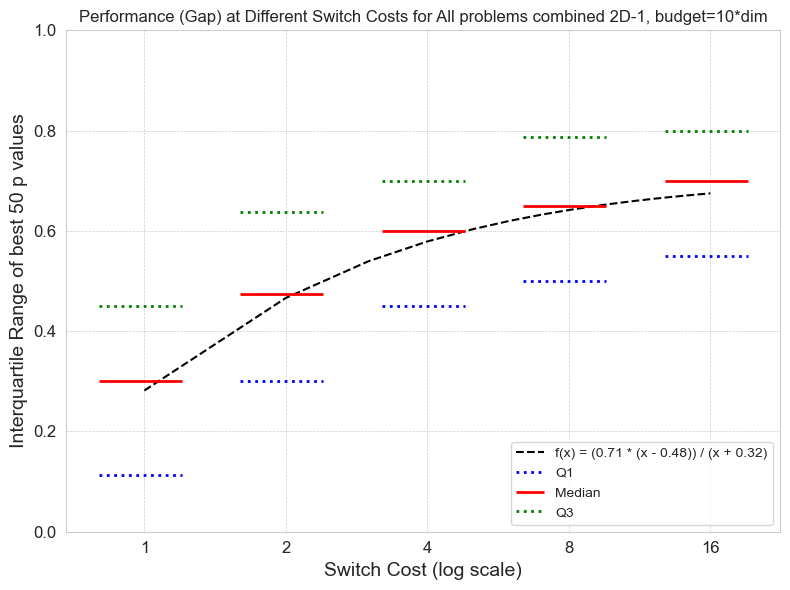

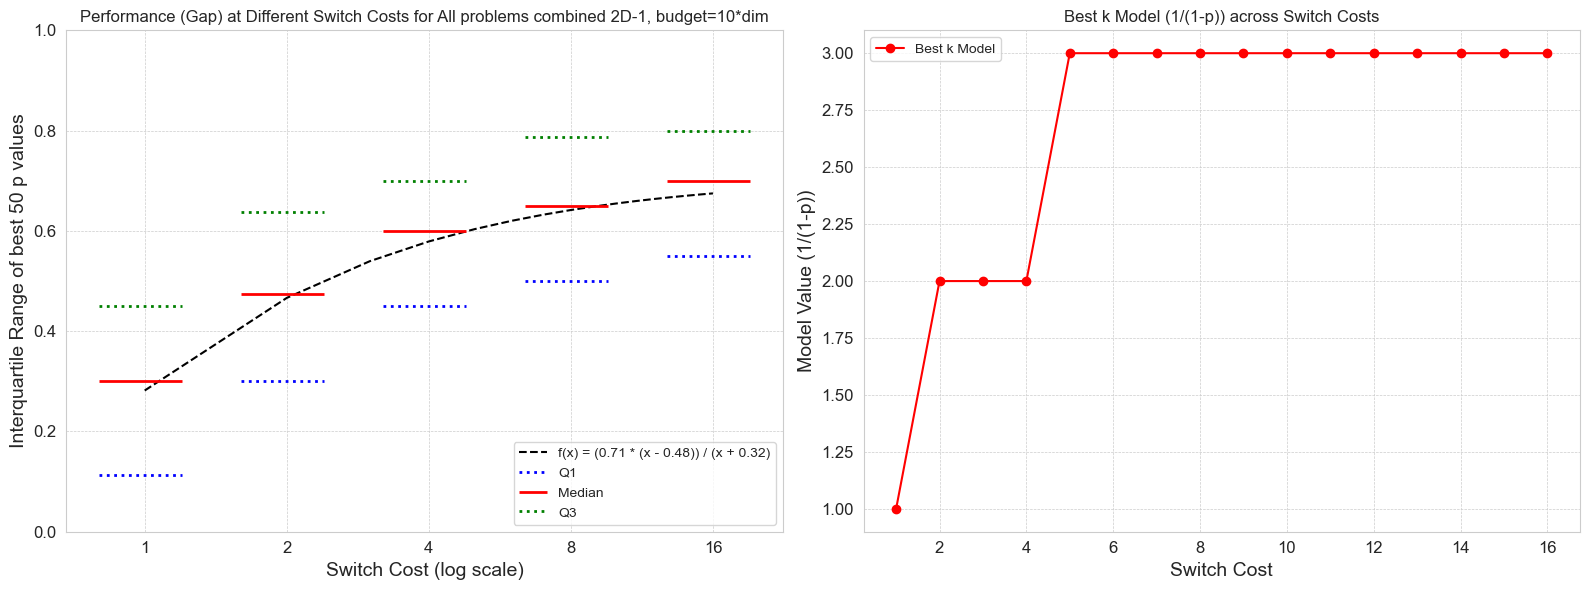

In [18]:
# Apply the function to the entire dataset
box_plot_switch(ptradeoff2d_results, 'All Problems Combined', top=50)
box_plot_switch(ptradeoff2d_results, 'All Problems Combined', top=50, best_k=True)

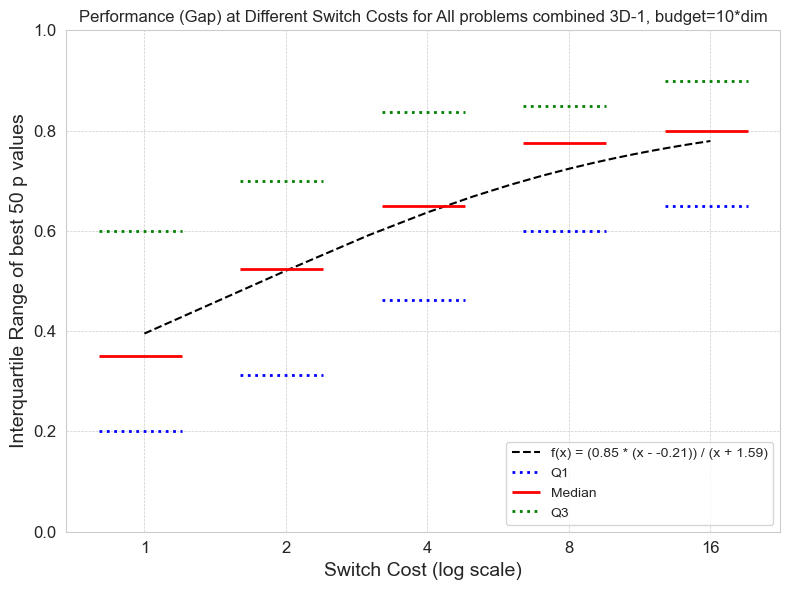

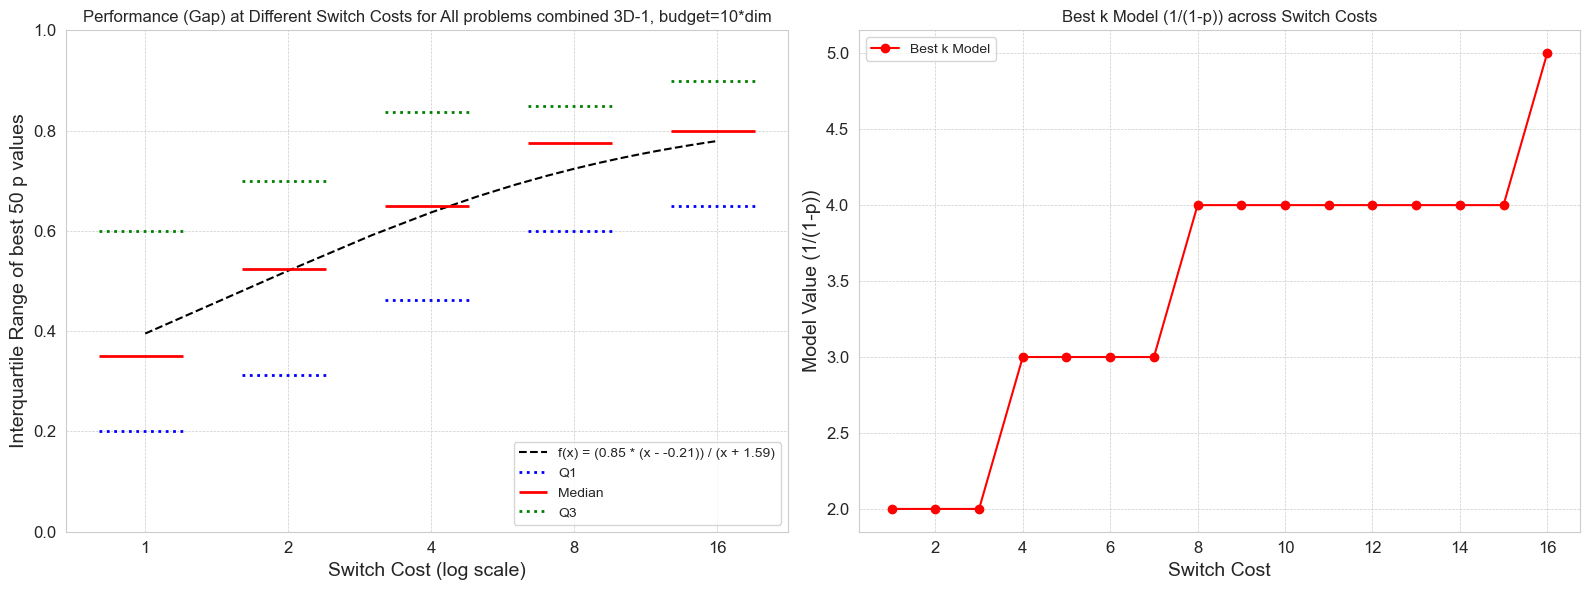

In [19]:
# Apply the function to the entire dataset
box_plot_switch(xcs1_3d, 'All Problems Combined', top=50)
box_plot_switch(xcs1_3d, 'All Problems Combined', top=50, best_k=True)

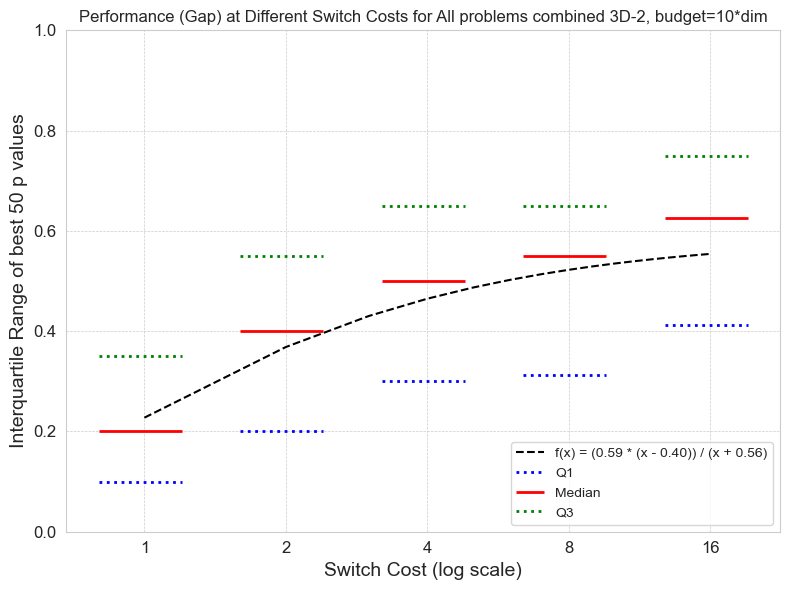

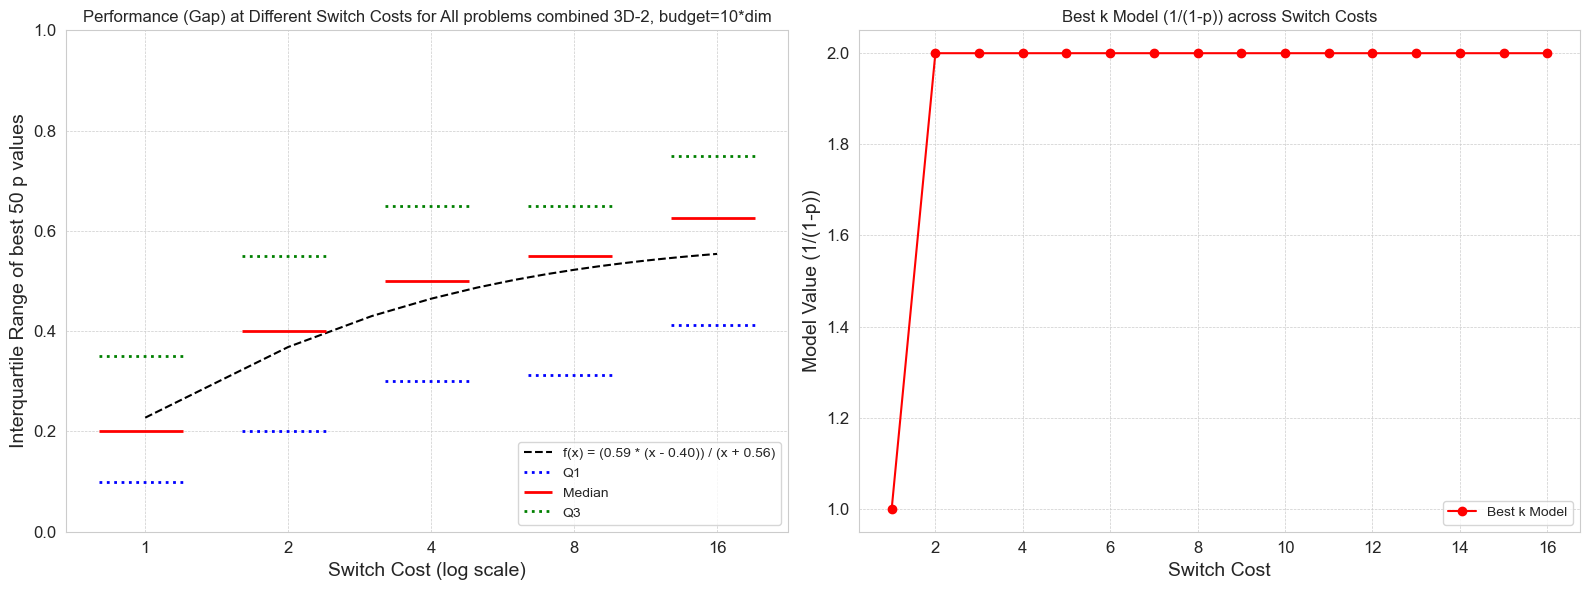

In [20]:
# Apply the function to the entire dataset
box_plot_switch(xcs2_3d, 'All Problems Combined', top=50)
box_plot_switch(xcs2_3d, 'All Problems Combined', top=50, best_k=True)

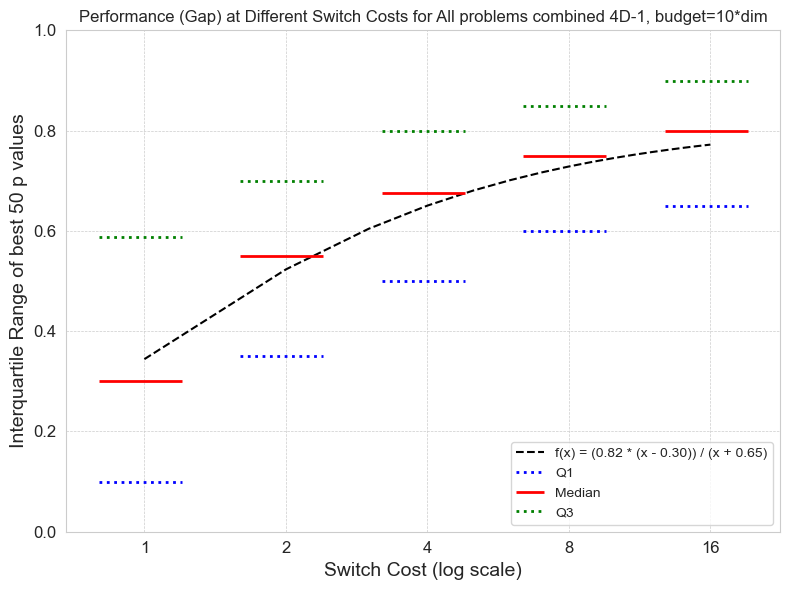

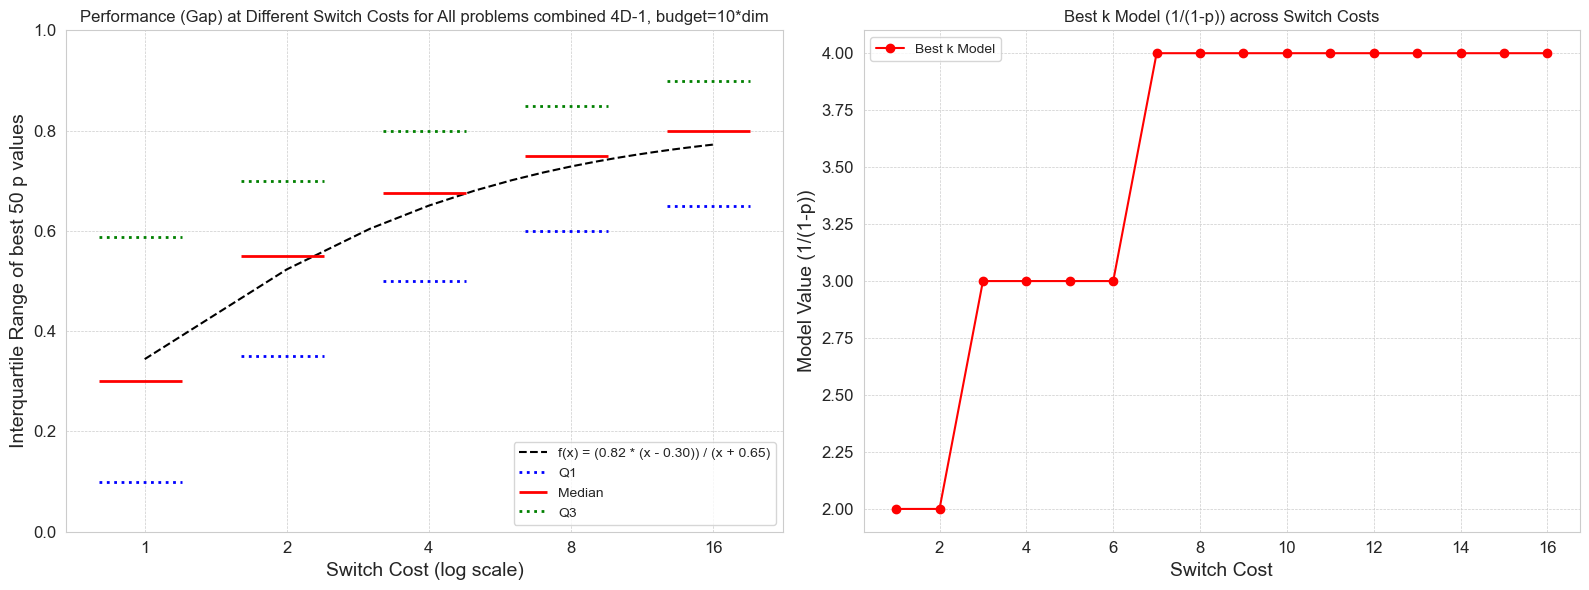

In [21]:
# Apply the function to the entire dataset
box_plot_switch(xcs1_4d, 'All Problems Combined', top=50)
box_plot_switch(xcs1_4d, 'All Problems Combined', top=50, best_k=True)

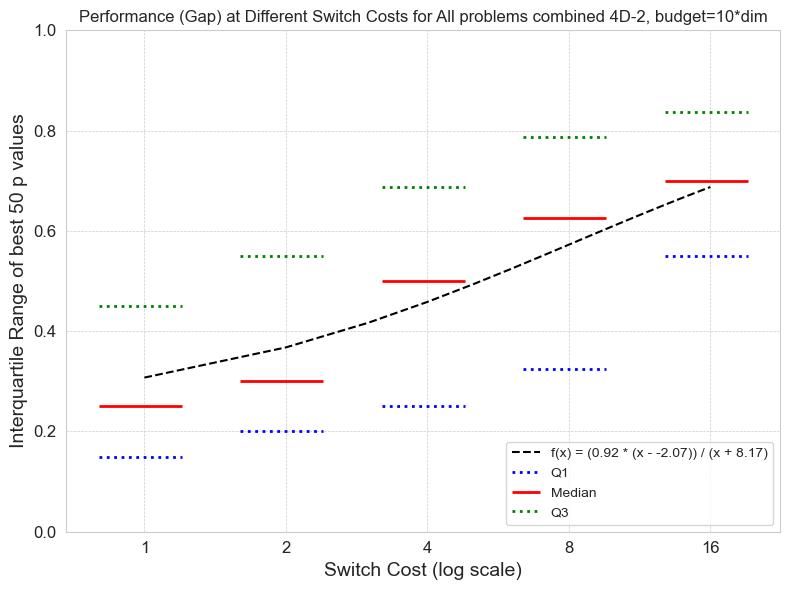

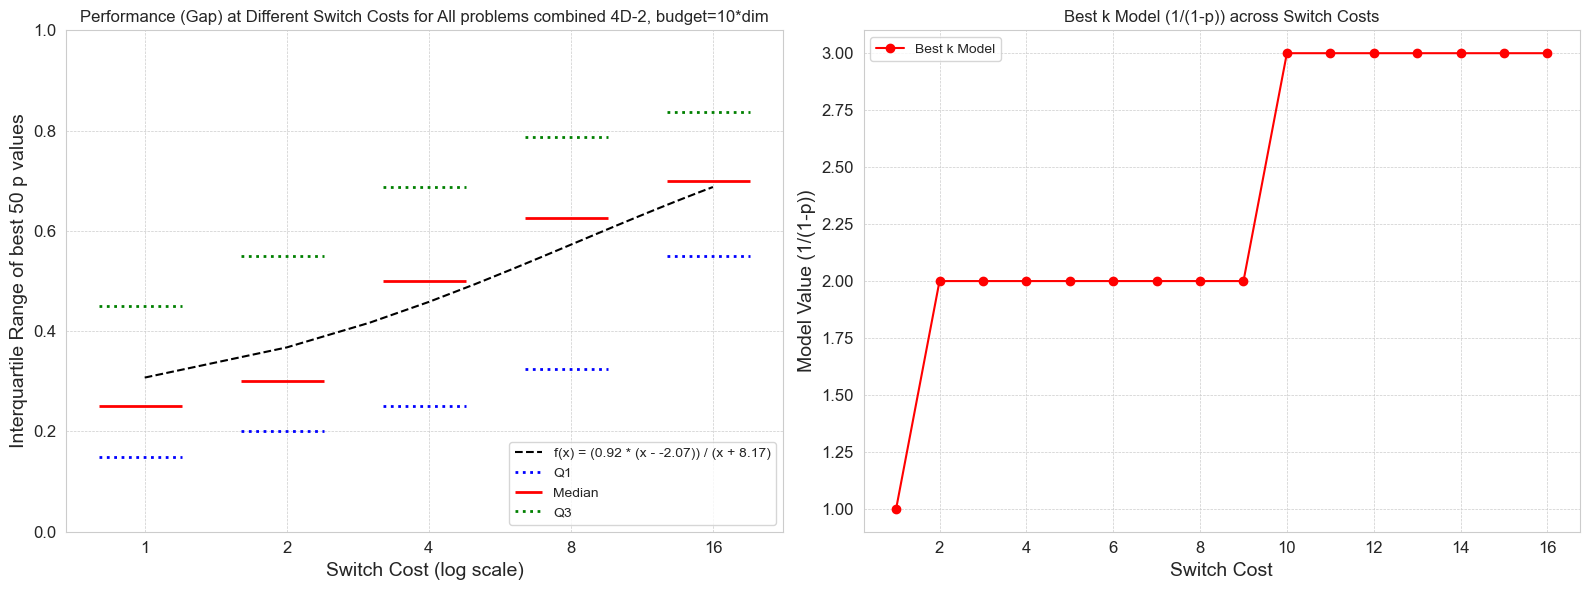

In [22]:
# Apply the function to the entire dataset
box_plot_switch(xcs2_4d, 'All Problems Combined', top=50)
box_plot_switch(xcs2_4d, 'All Problems Combined', top=50, best_k=True)

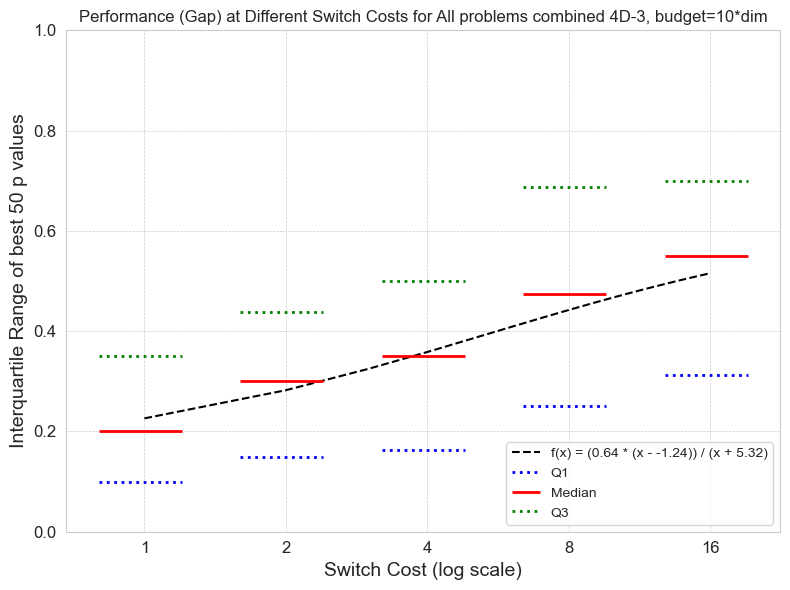

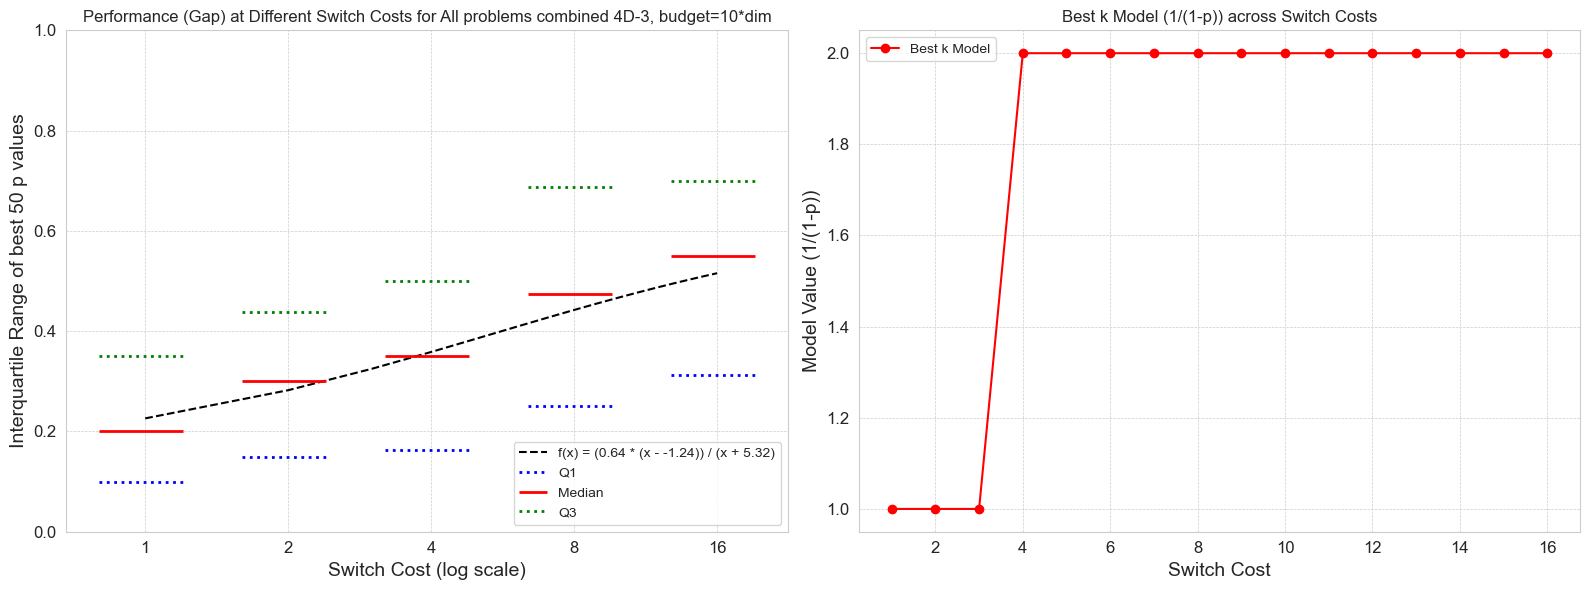

In [23]:
# Apply the function to the entire dataset
box_plot_switch(xcs3_4d, 'All Problems Combined', top=50)
box_plot_switch(xcs3_4d, 'All Problems Combined', top=50, best_k=True)

# Affect of p on performance standard BO $c=0$

In [24]:
# Function to plot performance gap for each problem
def plot_performance_gap(problem_df, problem_name):
    budgets = [20, 40, 60]

    # Set up the plot
    plt.figure(figsize=(8, 6))

    # Plot lines for multiple budgets
    performance = pd.DataFrame()
    for budget in budgets:
        # Calculate budget% for each budget
        problem_df['budget%'] = problem_df['index'] / budget

        # Filter the DataFrame for the last index of each budget
        budget_df = problem_df[problem_df['budget%'] < 1]

        # Groupby 'problem', 'p', 'run', and get the max gap
        performance_df = budget_df.groupby(['problem', 'p', 'run'])['gap'].max().reset_index()
        
        # Add budget column
        performance_df['budget'] = budget
        
        # Append to performance DataFrame
        performance = pd.concat([performance, performance_df], ignore_index=True)

    # Plot lineplot for each budget
    sns.lineplot(data=performance, x='p', y='gap', errorbar=('ci', 95), style='budget')

    # Plot vertical lines with annotations for each p
    ks = [2, 4, 8, 16]
    for k in ks:
        p_value = 1 - 1 / k
        plt.axvline(x=p_value, color='grey', linestyle='--')

        # Get current axes
        ax = plt.gca()

        # Adjust the text placement relative to the data coordinates and use transform to place text in axis coordinates
        ax.text(p_value, -0.05, f'k={k}', rotation=90, verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)

    # Finalize plot
    plt.title(f'Performance (Gap) at Different Budgets for {problem_name.capitalize()}')
    
    plt.xlabel(r'$p$ - Probability of Fixing Features')
    plt.ylabel('Performance Gap')
    
    plt.xlim(0, 1)
    
    plt.grid(True)
    
    plt.legend()
    plt.tight_layout()  # Adjust the layout
    plt.show()

In [25]:
# Apply the function to each problem
for problem_name, problem_df in all_results.groupby('problem'):
    plot_performance_gap(problem_df, problem_name)

NameError: name 'all_results' is not defined

In [ ]:
# Apply the function to the entire dataset
plot_performance_gap(all_results, 'All Problems Combined')

# Nr of evaluations for different ps with switch cost 8

In [ ]:
def hist_for_p(problem_df, problem_name, budget=10):
    # Ensure the operation is on a copy of the DataFrame to avoid SettingWithCopyWarning
    problem_df = problem_df.copy()

    switch_cost = 8

    # Filter dataframe for p in [0., 0.2, 0.4, 0.6, 0.8, 1.] and explicitly create a copy
    problem_df = problem_df[problem_df['p'].isin([0., 0.2, 0.4, 0.6, 0.8, 1.])].copy()

    # Replace switch_cost column
    problem_df['switch_cost'] = switch_cost

    # Map fixed_feature boolean to metric_c - if true then 1, else switch_cost
    problem_df['metric_c'] = problem_df['fixed_feature'].map({True: 1, False: switch_cost})

    # Groupby 'problem', 'p', 'run', and create "total_c" as the cumsum of "metric_c"
    problem_df['total_c'] = problem_df.groupby(['problem', 'p', 'run'])['metric_c'].cumsum()

    # Get dim value
    dim = problem_df['dim'].unique()[0]

    # Update budget for dim
    budget_dim = dim * budget

    # Calculate budget% for each budget
    problem_df['budget%'] = problem_df['total_c'] / (budget_dim * switch_cost)

    # Filter the DataFrame for the last index of each budget, ensure to copy
    budget_df = problem_df[problem_df['budget%'] <= 1].copy()

    # 1. Group by 'problem', 'p', 'run' and aggregate with several functions
    aggregated_df = budget_df.groupby(['problem', 'p', 'run']).agg(
        max_index=('index', 'max'),  # Get max of index
        sum_fixed_features=('fixed_feature', 'sum')  # Sum of fixed_features (True values)
    ).reset_index()
    
    # 2. Calculate the (sum of fixed_features)/(max index)
    aggregated_df['fixed_feature_ratio'] = aggregated_df['sum_fixed_features'] / aggregated_df['max_index']
        
    # 3. Calculate the budget% for fixed features
    aggregated_df['budget%_for_fixed_features'] = (aggregated_df['sum_fixed_features'] * switch_cost) / (budget_dim * switch_cost)

    # Plot histplot for each budget
    sns.histplot(data=aggregated_df, x='max_index', hue='p', stat='density', common_norm=False, element="poly")
    
    # min and max index
    min_index = aggregated_df['max_index'].min()
    max_index = aggregated_df['max_index'].max()
    
    # Set the modified tick labels back to the plot
    plt.xticks([min_index+5, max_index-5], [r'$B_{expensive}$', r'$B_{cheap}$'])

    plt.xlabel(r'$T$ - Number of Evaluations')
    plt.title(fr'$T$ across runs for different p values when switch cost={switch_cost}')
    plt.grid(False)
    plt.yticks([])
    plt.show()
    
    sns.histplot(data=aggregated_df, x='fixed_feature_ratio', hue='p', stat='density', common_norm=False, element="poly")
    plt.xlabel('Ratio of Fixed Features')
    plt.title('Ratio of fixed features across runs for different p values')
    plt.grid(False)
    plt.show()
    # sns.histplot(data=aggregated_df, x='budget%_for_fixed_features', hue='p', stat='density', common_norm=False, element="poly")
    # plt.show()

In [ ]:
hist_for_p(all_results, 'All Problems Combined', budget=10)

# Relationship between p and switch cost
## Best 100 gaps for each switch cost

In [ ]:
def top100(problem_df, problem_name, budget=10):

    # Set up the plot
    plt.figure(figsize=(12, 6))

    switch_costs = [1, 2, 4, 8, 16]

    # Plot lines for multiple budgets
    performance = pd.DataFrame()
    for switch_cost in switch_costs:
        # Replace switch_cost column
        problem_df['switch_cost'] = switch_cost

        # Map fixed_feature boolean to metric_c - if true then 1, else switch_cost
        problem_df['metric_c'] = problem_df['fixed_feature'].map({True: 1, False: switch_cost})

        # Groupby 'problem', 'p', 'run', and create "total_c" as the cumsum of "metric_c"
        problem_df['total_c'] = problem_df.groupby(['problem', 'p', 'run'])['metric_c'].cumsum()

        # Get dim value
        dim = problem_df['dim'].unique()[0]
    
        # Update budget for dim
        budget_dim = dim * budget
    
        # Calculate budget% for each budget
        problem_df['budget%'] = problem_df['total_c'] / (budget_dim * switch_cost)

        # Filter the DataFrame for the last index of each budget
        budget_df = problem_df[problem_df['budget%'] <= 1]

        # Groupby 'problem', 'p', 'run', and get the max gap
        performance_df = budget_df.groupby(['problem', 'p', 'run', 'switch_cost'])['gap'].max().reset_index()

        # Append to performance DataFrame
        performance = pd.concat([performance, performance_df], ignore_index=True)

    # Assuming 'performance' is already populated with the relevant data as per your loop
    performance = performance.groupby(['p', 'run', 'switch_cost'])['gap'].mean().reset_index()

    # Get the top 100 gaps per switch cost
    # First, sort the DataFrame by 'switch_cost' and 'gap' descending
    sorted_performance = performance.sort_values(by=['switch_cost', 'gap'], ascending=[True, False])

    # Then, group by 'switch_cost' and get the top 100 rows for each group
    top_gaps_per_switch_cost = sorted_performance.groupby('switch_cost').head(100).reset_index(drop=True)

    # Scatter plot
    # Plot lineplot for each budget
    sns.histplot(data=top_gaps_per_switch_cost, x='p', hue = "switch_cost", element="poly")
    plt.title(f'Performance (Gap) at Different Costs for {problem_name.capitalize()}')

In [ ]:
# Apply the function to the entire dataset
top100(all_results, 'All Problems Combined', budget=30)

In [ ]:
# Apply the function to the entire dataset
top100(all_results, 'All Problems Combined', budget=10)

# Effect of expensive dim on performance (4D)

In [ ]:
# Group by 'problem', 'dim', 'xcs', 'p', and 'run', and count each group
counts_evals = all4d_results.groupby(['problem', 'dim', 'xcs', 'p', 'run']).size().reset_index(name='count')
counts_evals.head()

In [ ]:
# Group by 'problem', 'p', and 'run', and count each group
counts_ps = counts_evals.groupby(['problem', 'dim', 'xcs', 'p',]).size().reset_index(name='count')
counts_ps.head()

In [ ]:
# Group by problem, sum counts
counts_problems = counts_ps.groupby(['problem', 'dim', 'xcs'])["count"].sum().reset_index()
counts_problems

# Affect of p on performance standard BO $c=0$

In [ ]:
# Function to plot performance gap for each problem
def plot_gap_based_on_dim(problem_df, problem_name):
    budget = 60

    # Set up the plot
    plt.figure(figsize=(12, 6))
    
    switch_cost = 8

    # Replace switch_cost column
    problem_df['switch_cost'] = switch_cost

    # Map fixed_feature boolean to metric_c - if true then 1, else switch_cost
    problem_df['metric_c'] = problem_df['fixed_feature'].map({True: 1, False: switch_cost})

    # Groupby 'problem', 'p', 'run', and create "total_c" as the cumsum of "metric_c"
    problem_df['total_c'] = problem_df.groupby(['problem', 'dim', 'xcs', 'p', 'run'])['metric_c'].cumsum()

    # Calculate budget% for each budget
    problem_df['budget%'] = problem_df['total_c'] / (budget * switch_cost)

    # Filter the DataFrame for the last index of each budget
    budget_df = problem_df[problem_df['budget%'] <= 1]

    # Plot lines for multiple xcs
    # Groupby 'problem', 'p', 'run', and get the max gap
    performance_df = budget_df.groupby(['problem', 'dim', 'xcs', 'p', 'run'])['gap'].max().reset_index()

    # Plot lineplot for each budget
    sns.lineplot(data=performance_df, x='p', y='gap', errorbar=('ci', 95), style='xcs')

    # Plot vertical lines with annotations for each p
    ks = [2, 4, 8, 16]
    for k in ks:
        p_value = 1 - 1 / k
        plt.axvline(x=p_value, color='grey', linestyle='--')

        # Get current axes
        ax = plt.gca()

        # Adjust the text placement relative to the data coordinates and use transform to place text in axis coordinates
        ax.text(p_value, -0.05, f'k={k}', rotation=90, verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)

    # Finalize plot
    plt.title(f'Performance (Gap) at Different Budgets for {problem_name.capitalize()}')
    plt.xlabel(r'$p$ - Probability of Fixing Features')
    plt.ylabel('Performance Gap')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()  # Adjust the layout
    plt.show()

In [ ]:
# Apply the function to each problem
for problem_name, problem_df in all4d_results.groupby('problem'):
    plot_gap_based_on_dim(problem_df, problem_name)

In [ ]:
# Apply the function to the entire dataset
plot_gap_based_on_dim(all4d_results, 'All Problems Combined')